## Transfer learning

In [1]:
# Load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from random import shuffle
import os, gc, time, cv2, random, math

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import glob
from zipfile import ZipFile

zip_file = glob.glob('../input/dogs-vs-cats-redux-kernels-edition/*.zip')  #return any files with .zip extension
print(zip_file)

#extract file into a temp folder
def extract_zip(file):
    with ZipFile(file,'r') as zip_ref:
        zip_ref.extractall('.')
        
#extract both train and test1 zip
for files in zip_file:
    extract_zip(files)

['../input/dogs-vs-cats-redux-kernels-edition/train.zip', '../input/dogs-vs-cats-redux-kernels-edition/test.zip']


In [3]:
# global constants
RESNET_WEIGHTS_PATH = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
TRAIN_DIR = ('../working/train')
TEST_DIR =  ('../working/test')
NUM_CLASSES = 2
IMG_SIZE = 145  ###
CHANNELS = 3
EPOCHS = 15
BATCH_SIZE = 32

train_images = os.listdir(TRAIN_DIR)
test_images = os.listdir(TEST_DIR)

# # For testing purposes
# train_images = train_images[:10000]
# test_images = test_images[:100]

In [4]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return 0  ###
    elif word_label == 'dog' : return 1  ###

# Return a numpy array of train and test data
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        if(isTrain):
            label = label_img(img)
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img), label])
    shuffle(data_df)
    return data_df

In [5]:
# Prepare the train data
train_data = process_data(train_images, TRAIN_DIR, isTrain=True)
X = np.array([i[0] for i in train_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array([i[1] for i in train_data])

100%|██████████| 25000/25000 [00:52<00:00, 475.16it/s]


## Build the Model

In [6]:
import keras.backend as K
from keras.applications import ResNet50
from keras.models import Model
from keras import optimizers
from keras.layers import Conv2D, Dense, Input, Flatten, Concatenate, Dropout, Activation
from keras.layers import BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras import applications

def get_pretrained_model(Weights_path='imagenet', trainable=False, Input_Shape=None):
    input_shape = Input_Shape
    base_model = ResNet50(weights=None, include_top=False, input_shape= input_shape)
    base_model.load_weights(Weights_path)
    for l in base_model.layers:
        l.trainable = trainable
    return base_model
    
def build_model(PreModel, LearningRate=1e-3, Decay=1e-8):
    
    input_x = PreModel.inputs
    
    x_model = PreModel.output #(None, 1, 1, 2048)
    x_model = Flatten()(x_model)
    
    x_model = Dense(64, activation='relu',name='fc1_Dense')(x_model)
    #x_model = Dropout(0.5, name='dropout_1')(x_model)
    x_model = BatchNormalization()(x_model)
    
    x_model = Dense(32, activation='relu',name='fc2_Dense')(x_model)
    #x_model = Dropout(0.5, name='dropout_2')(x_model)
    x_model = BatchNormalization()(x_model)
    
    predictions = Dense(1, activation='sigmoid',name='output_layer')(x_model)
    model = Model(inputs=input_x, outputs=predictions)
    optimizer = optimizers.Adam(lr=LearningRate, decay=Decay)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

PreModel = get_pretrained_model(Weights_path=RESNET_WEIGHTS_PATH,
                                trainable=False,
                                Input_Shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
model = build_model(PreModel, LearningRate=1e-3, Decay=1e-8)

Using TensorFlow backend.


In [7]:
# Model Summary
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

# model.summary()
# plot_model(model, to_file='model.png')
# SVG(model_to_dot(model).create(prog='dot', format='svg'))
# Trainable layers
for l in model.layers:
    if l.trainable: print(l.name)

flatten_1
fc1_Dense
batch_normalization_1
fc2_Dense
batch_normalization_2
output_layer


## Training

In [8]:
from sklearn.model_selection import train_test_split
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=1)

# Augmentation configuration to use for training and validation
train_datagen = ImageDataGenerator(
        #rescale=1./255,#!!!!!
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20, 
        horizontal_flip=True,
        preprocessing_function=preprocess_input
)
test_datagen = ImageDataGenerator(
    #rescale=1./255,#!!!!!
    preprocessing_function=preprocess_input
)

In [9]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
BestModelWeightsPath = 'BestModel.hdf5'
check_point = ModelCheckpoint(
    BestModelWeightsPath, monitor='val_loss', verbose=1,
    save_best_only=True, 
    save_weights_only=True,
    mode='min'
)
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=3, verbose=1)
earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=30)
callbacks_list = [check_point, lr_reduce, earlyStop]

K.set_value(model.optimizer.lr, 0.0001)
gc.collect()
history = model.fit_generator(
    train_datagen.flow(np.array(X_train), y_train, batch_size=BATCH_SIZE, shuffle=True),
    steps_per_epoch= len(X) // BATCH_SIZE,
    validation_data = test_datagen.flow(np.array(X_val), y_val, batch_size=BATCH_SIZE*3, shuffle=False),
    validation_steps = len(X_val) // (BATCH_SIZE*3),
    epochs=EPOCHS,
    shuffle=False,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/15
781/781 [==============================] - 144s 184ms/step - loss: 0.1957 - acc: 0.9184 - val_loss: 0.0948 - val_acc: 0.9663

Epoch 00001: val_loss improved from inf to 0.09480, saving model to BestModel.hdf5
Epoch 2/15
781/781 [==============================] - 133s 170ms/step - loss: 0.1432 - acc: 0.9436 - val_loss: 0.1281 - val_acc: 0.9560

Epoch 00002: val_loss did not improve from 0.09480
Epoch 3/15
781/781 [==============================] - 133s 170ms/step - loss: 0.1363 - acc: 0.9450 - val_loss: 0.0892 - val_acc: 0.9670

Epoch 00003: val_loss improved from 0.09480 to 0.08923, saving model to BestModel.hdf5
Epoch 4/15
781/781 [==============================] - 132s 169ms/step - loss: 0.1186 - acc: 0.9543 - val_loss: 0.1066 - val_acc: 0.9629

Epoch 00004: val_loss did not improve from 0.08923
Epoch 5/15
781/781 [==============================] - 132s 169ms/step - loss: 0.1108 - acc: 0.9579 - val_loss: 0.0935 - val_acc: 0.9676

Epoch 00005: val_loss did not improve from 

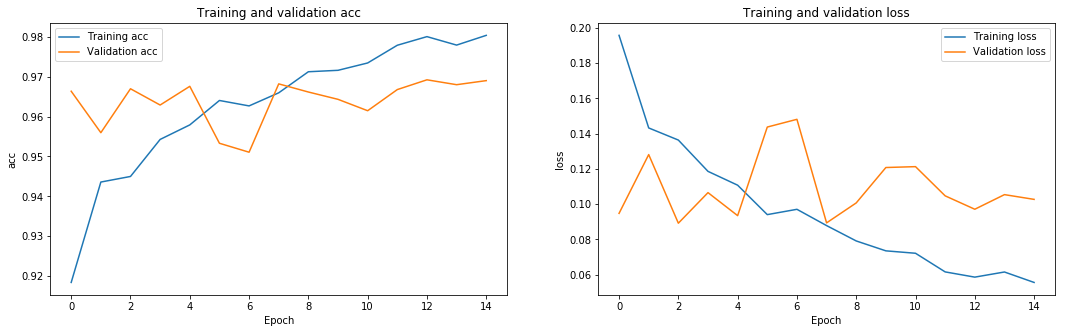

In [10]:
# Plotting loss and accuracy for the model
def plot_accuracy_and_loss(history):
    eval_res = pd.DataFrame(history.history)
    f, ax = plt.subplots(1,2, figsize=(18,5))
    for i, c in enumerate(['acc', 'loss']):
        ax[i].plot(eval_res[[c]], label=f'Training {c}')
        ax[i].plot(eval_res[[f'val_{c}']], label=f'Validation {c}')
        ax[i].set_xlabel('Epoch'); ax[i].set_ylabel(c);
        ax[i].legend(); ax[i].set_title(f'Training and validation {c}'); plt.grid();
    plt.show()
plot_accuracy_and_loss(history)

## Fine-tuning

In [11]:
last_5_layer_names = [_.name for _ in PreModel.layers[::-1][:5]]
print(f'Pretrained have {len(PreModel.layers)} layers')
print(f'My model have {len(model.layers)} layers')
print(f'Pretrained last 5 layers: ', last_5_layer_names, '\n')

# for l in model.layers[:]: # enable training just for all layers
for l in model.layers[::-1][6:12]: # enable training just for last five layers of the Restnet50
    print('Fine-tune', l.name);
    l.trainable = True

Pretrained have 175 layers
My model have 181 layers
Pretrained last 5 layers:  ['activation_49', 'add_16', 'bn5c_branch2c', 'res5c_branch2c', 'activation_48'] 

Fine-tune activation_49
Fine-tune add_16
Fine-tune bn5c_branch2c
Fine-tune res5c_branch2c
Fine-tune activation_48
Fine-tune bn5c_branch2b


In [12]:
BestModelWeightsPath = 'BestModel.hdf5'
check_point = ModelCheckpoint(
    BestModelWeightsPath, monitor='val_loss', verbose=1,
    save_best_only=True, 
    save_weights_only=True,
    mode='min'
)
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=3, verbose=1)
earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=30)
callbacks_list = [check_point, lr_reduce, earlyStop]

K.set_value(model.optimizer.lr, 1e-6) ###
K.set_value(model.optimizer.decay, 1e-9)
gc.collect()
history = model.fit_generator(
    train_datagen.flow(np.array(X_train), y_train, batch_size=BATCH_SIZE, shuffle=True),
    steps_per_epoch= len(X) // BATCH_SIZE,
    validation_data = test_datagen.flow(np.array(X_val), y_val, batch_size=BATCH_SIZE*3, shuffle=False),
    validation_steps = len(X_val) // (BATCH_SIZE*3),
    epochs=math.ceil(EPOCHS*1.6), ###
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/24
781/781 [==============================] - 134s 172ms/step - loss: 0.0521 - acc: 0.9815 - val_loss: 0.1028 - val_acc: 0.9690

Epoch 00001: val_loss improved from inf to 0.10280, saving model to BestModel.hdf5
Epoch 2/24
781/781 [==============================] - 130s 167ms/step - loss: 0.0551 - acc: 0.9811 - val_loss: 0.1031 - val_acc: 0.9692

Epoch 00002: val_loss did not improve from 0.10280
Epoch 3/24
781/781 [==============================] - 131s 168ms/step - loss: 0.0529 - acc: 0.9816 - val_loss: 0.1009 - val_acc: 0.9698

Epoch 00003: val_loss improved from 0.10280 to 0.10088, saving model to BestModel.hdf5
Epoch 4/24
781/781 [==============================] - 131s 167ms/step - loss: 0.0570 - acc: 0.9790 - val_loss: 0.1019 - val_acc: 0.9694

Epoch 00004: val_loss did not improve from 0.10088
Epoch 5/24
781/781 [==============================] - 131s 168ms/step - loss: 0.0551 - acc: 0.9809 - val_loss: 0.1021 - val_acc: 0.9694

Epoch 00005: val_loss did not improve from 

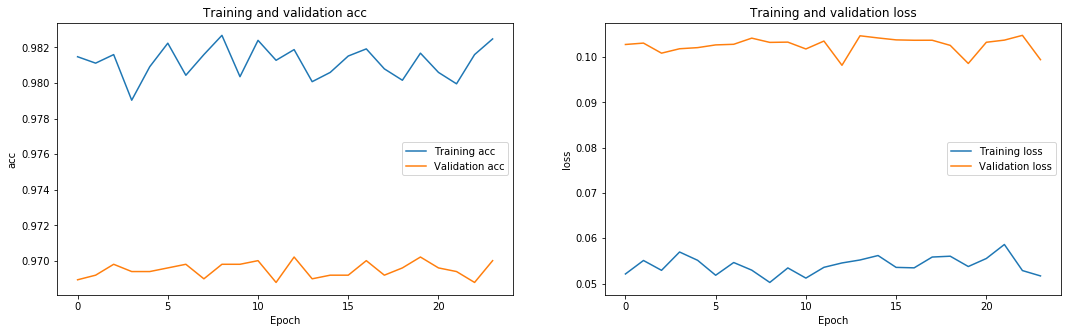

In [13]:
plot_accuracy_and_loss(history)

## Testing

100%|██████████| 12500/12500 [00:29<00:00, 428.77it/s]


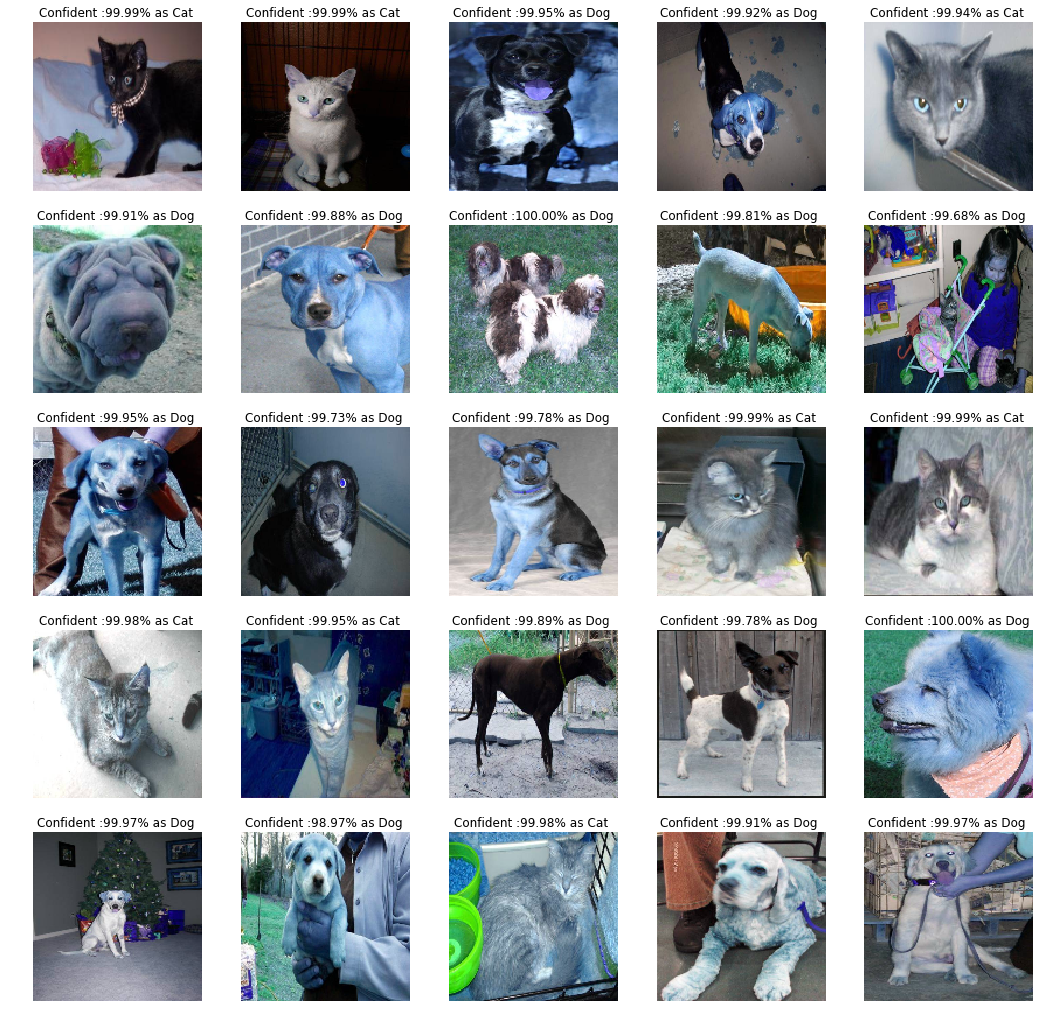

In [14]:
# Free some memory
del X, y, train_data; gc.collect()

# Load Best model weights
model.load_weights(BestModelWeightsPath)

# Testing Model on Test Data
test_data = process_data(test_images, TEST_DIR, isTrain=False)
f, ax = plt.subplots(5,5, figsize=(18,18))
for i,data in enumerate(test_data[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    data = preprocess_input(data)
    model_out = model.predict([data])[0]
    if model_out[0] >= 0.5: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Confident :{:.2%} as {} ".format(abs(0.5-model_out[0])*2, str_predicted))    
plt.show()

## Comments
- Due to memory limitations, I was obliged to reduce the Batch-size and Image-size.
- Same data processing for validation and test images, i used this function **preprocess_input(data)**.
- I was having vaidation accuracy higher then training accuracy, so i corrected some suffle values, so my model will not use some data in both training and validation.
- **Fine-Tuning**: unfreezing some or all layers from Resnet 50 base layers and retraining using the previous best weights and a very small learning rate
- I passed all day predicing Dog as 0 and cat as 1 and getting scores greeter then 1. I was testing different parameters, but predicting the reverse was a stupid thing
- 
